# Return period - code
> Let's calculate the intensity of once-in-a-century rainfall

- toc: false 
- badges: true
- comments: false
- categories: [jupyter]

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import re
import probscale
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import urllib.request

In [2]:
def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
#     download daily data - uncomment to make this work
    urllib.request.urlretrieve(url_daily + station_code + '.csv',
                               station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

In [6]:
download_data('BILBAO', 'SPE00120611')

In [3]:
df = pd.read_csv('BILBAO_daily.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
# IMPORTANT!! daily precipitation data is in tenths of mm, divide by 10 to get it in mm.
df['PRCP'] = df['PRCP'] / 10

<IPython.core.display.Javascript object>


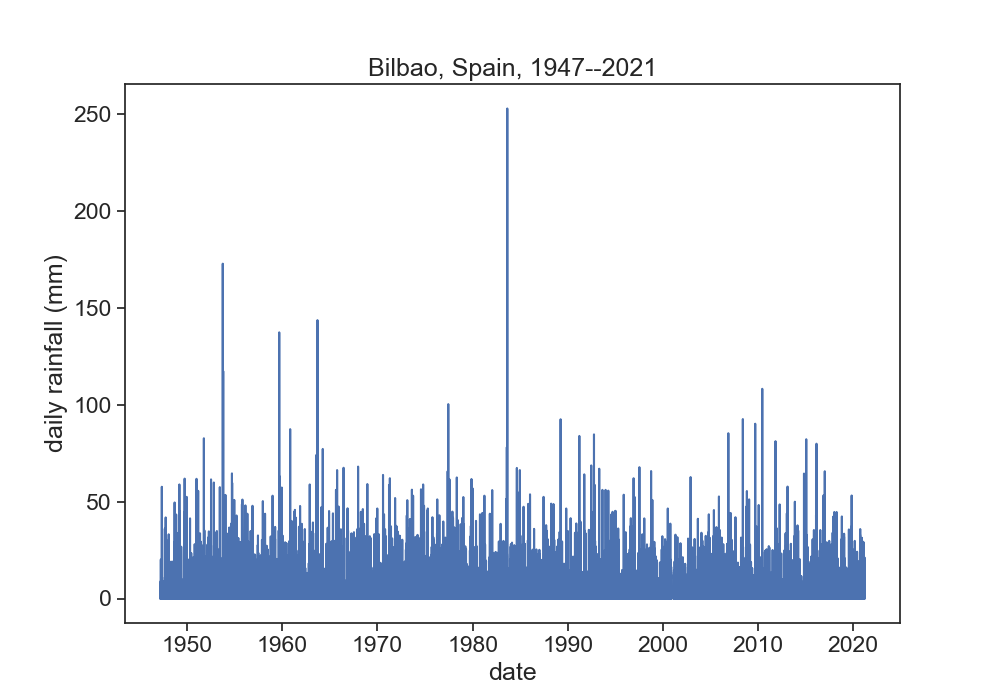

In [6]:
# %matplotlib notebook
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df['PRCP'])
ax.set_xlabel("date")
ax.set_ylabel("daily rainfall (mm)")
ax.set_title("Bilbao, Spain, 1947--2021")
ax.annotate("26 August 1983",
             xy=('1983-08-26', 2500), xycoords='data',
             xytext=(0.7, 0.95), textcoords='axes fraction',
             fontsize=16, va="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig("hydrology_figures/bilbao-1947-2021.png")

<IPython.core.display.Javascript object>


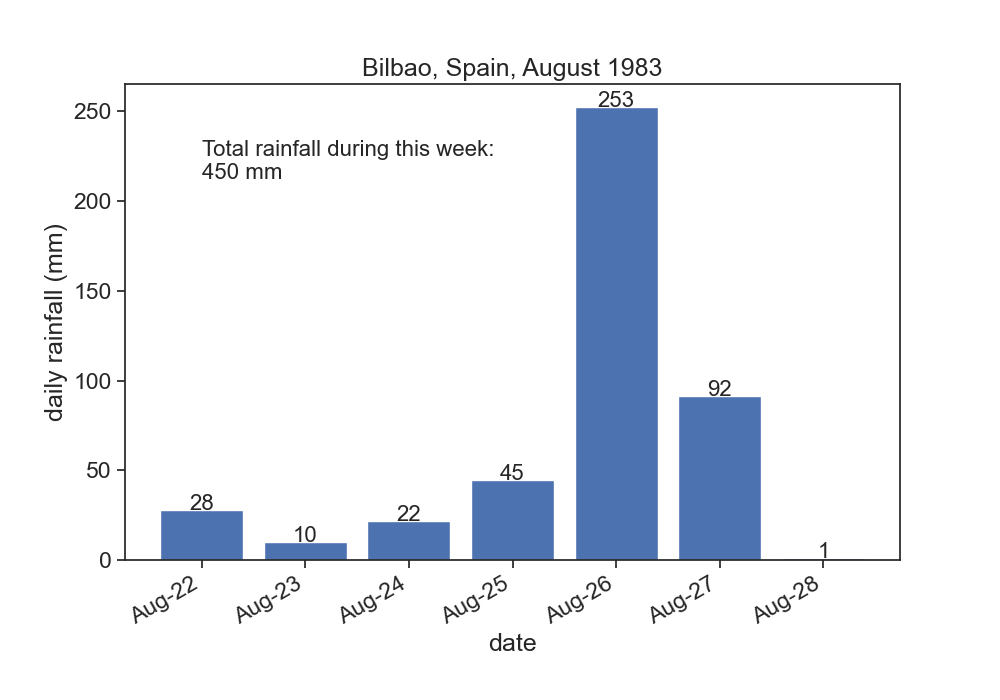

In [7]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib

fig, ax = plt.subplots(figsize=(10,7))
one_week = df.loc['1983-08-22':'1983-08-28', 'PRCP']
bars = ax.bar(one_week.index, one_week)
ax.set_xlabel("date")
ax.set_ylabel("daily rainfall (mm)")
ax.set_title("Bilbao, Spain, August 1983")

# write daily rainfall
for i in range(len(one_week)):
    ax.text(one_week.index[i], one_week[i], f"{one_week[i]:.0f}", ha="center", fontsize=16)

ax.text(0.1, 0.8, f"Total rainfall during this week:\n{one_week.sum():.0f} mm",
        transform=ax.transAxes, fontsize=16)
    
# Define the date format
# https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
date_form = DateFormatter("%b-%d")
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for each day using (interval=1)
# https://matplotlib.org/stable/api/dates_api.html#date-tickers
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.savefig("hydrology_figures/bilbao-august-1983.png")

In [8]:
import altair as alt
alt.data_transformers.disable_max_rows()

df_new = df.reset_index()#.replace({0.0:np.nan})
source = df_new[['DATE', 'PRCP']]

brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(source).mark_line().encode(
    x = 'DATE:T',
    y = 'PRCP:Q'
).properties(
    width=600,
    height=200
)

upper = base.encode(
    alt.X('DATE:T', scale=alt.Scale(domain=brush)),
    alt.Y('PRCP:Q', scale=alt.Scale(domain=(0,500)))
)

lower = base.properties(
    height=60
).add_selection(brush)

alt.vconcat(upper, lower)

alt.VConcatChart(...)

In [9]:
df_month = df['PRCP'].resample('M').sum().to_frame()
month_numbers = np.arange(1,13)
monthly_mean = np.array([])  # empty array
for m in month_numbers:      # cycle over months (1, 2, 3, etc)
    this_month_mean = df_month[df_month.index.month == m].mean()  # this is the monthly mean
    monthly_mean = np.append(monthly_mean, this_month_mean)    # append
    # make new df and return it
df_month = pd.DataFrame({'monthly rainfall (mm)':monthly_mean,
                          'month number':month_numbers
                         })
df_month

,monthly rainfall (mm),month number
0,130.254054,1
1,103.468919,2
2,95.350667,3
3,107.420270,4
4,84.037838,5
5,64.563514,6
6,50.702703,7
7,69.922973,8
8,85.070270,9
9,117.237838,10


<IPython.core.display.Javascript object>


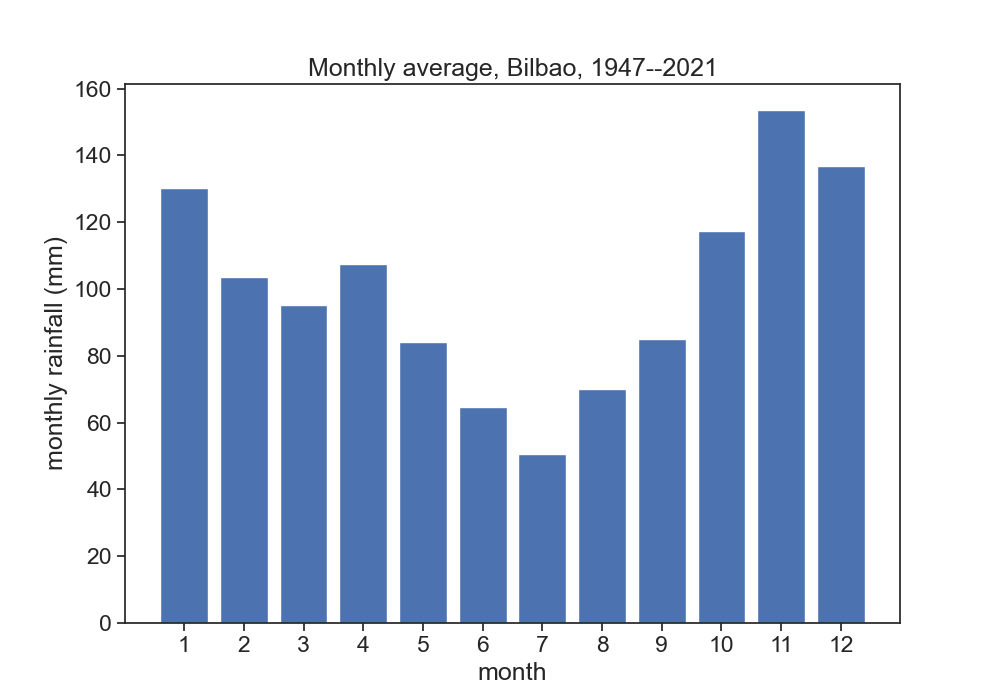

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_month['month number'], df_month['monthly rainfall (mm)'])
ax.set(xlabel="month",
       ylabel="monthly rainfall (mm)",
       title="Monthly average, Bilbao, 1947--2021",
       xticks=np.arange(1,13))
plt.savefig("hydrology_figures/monthly_average_bilbao.png")

## Let's rank the annual max

In [11]:
# resample daily data into yearly data (maximum yearly value)
# hydrologic year starts in August
max_annual = df['PRCP'].resample('A-JUL').max().to_frame()
# sort yearly max from highest to lowest
max_annual = max_annual.sort_values(by=['PRCP'], ascending=False)
max_annual['rank'] = np.arange(1, len(max_annual) + 1)
# print(max_annual)
max_annual

,PRCP,rank
DATE,,
1984-07-31,252.6,1
1954-07-31,172.6,2
1964-07-31,143.5,3
1960-07-31,137.2,4
2010-07-31,108.1,5
...,...,...
2004-07-31,41.1,71
2001-07-31,38.6,72
2021-07-31,35.8,73


<IPython.core.display.Javascript object>


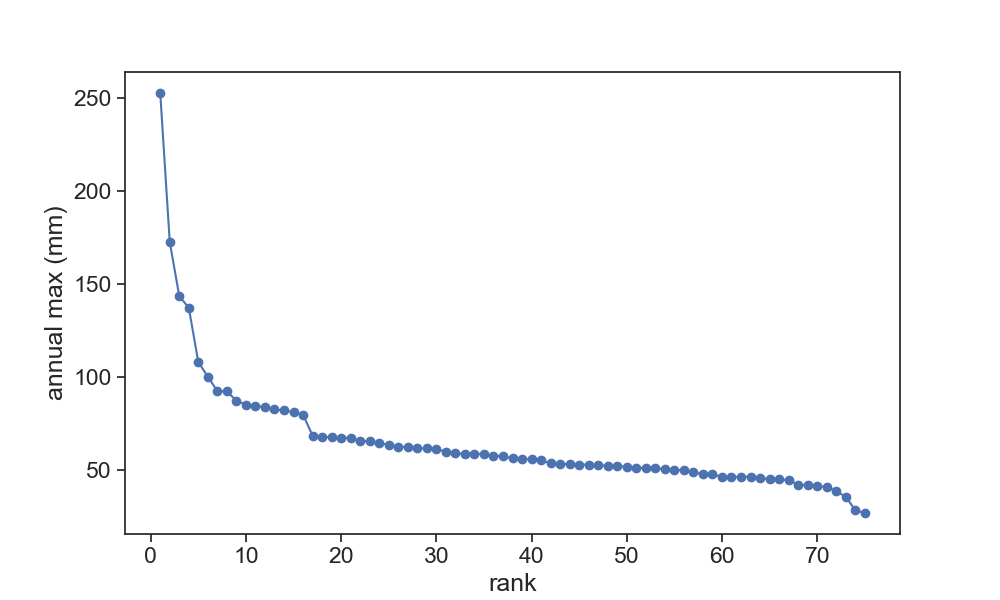

[Text(0.5, 0, 'rank'), Text(0, 0.5, 'annual max (mm)')]

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))

# plot annual max vs. rank
ax.plot(max_annual['rank'], max_annual['PRCP'], '-o')
plt.gca().set(xlabel="rank", ylabel="annual max (mm)")

<IPython.core.display.Javascript object>


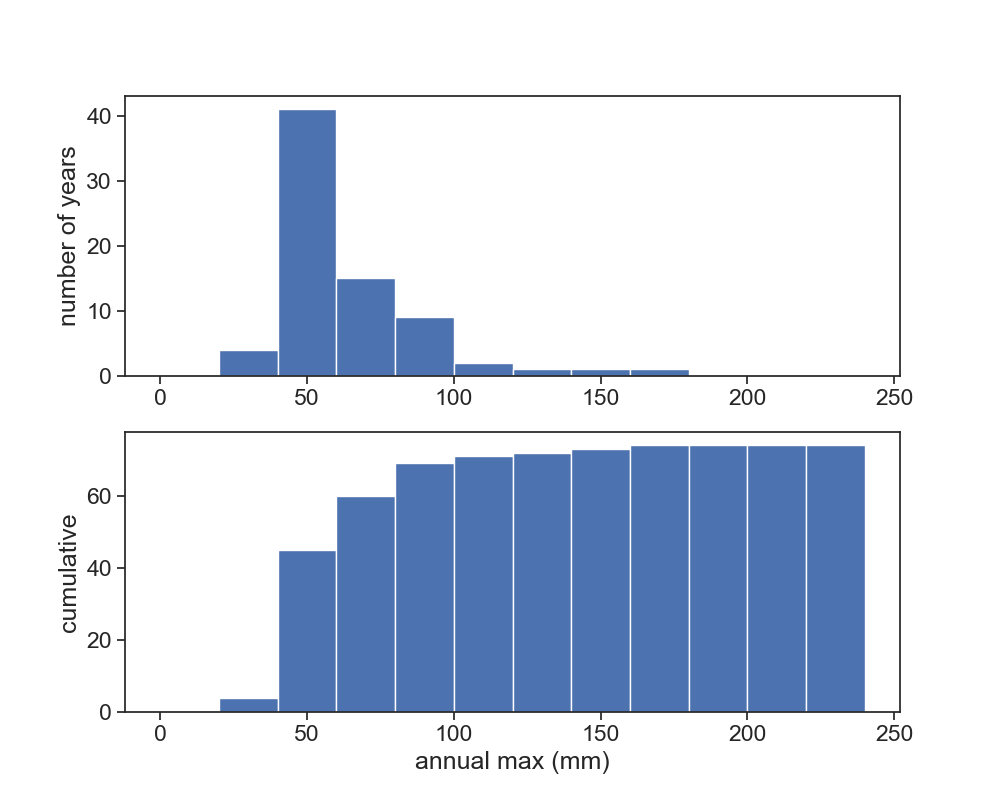

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

h=max_annual['PRCP'].values
ax1.hist(h, bins=np.arange(0,250,20))
ax2.hist(h, bins=np.arange(0,250,20), cumulative=1)

ax1.set(ylabel="number of years")
ax2.set(xlabel="annual max (mm)",
        ylabel="cumulative")
plt.savefig("hydrology_figures/hist_count_cumulative_bilbao.png")

<IPython.core.display.Javascript object>


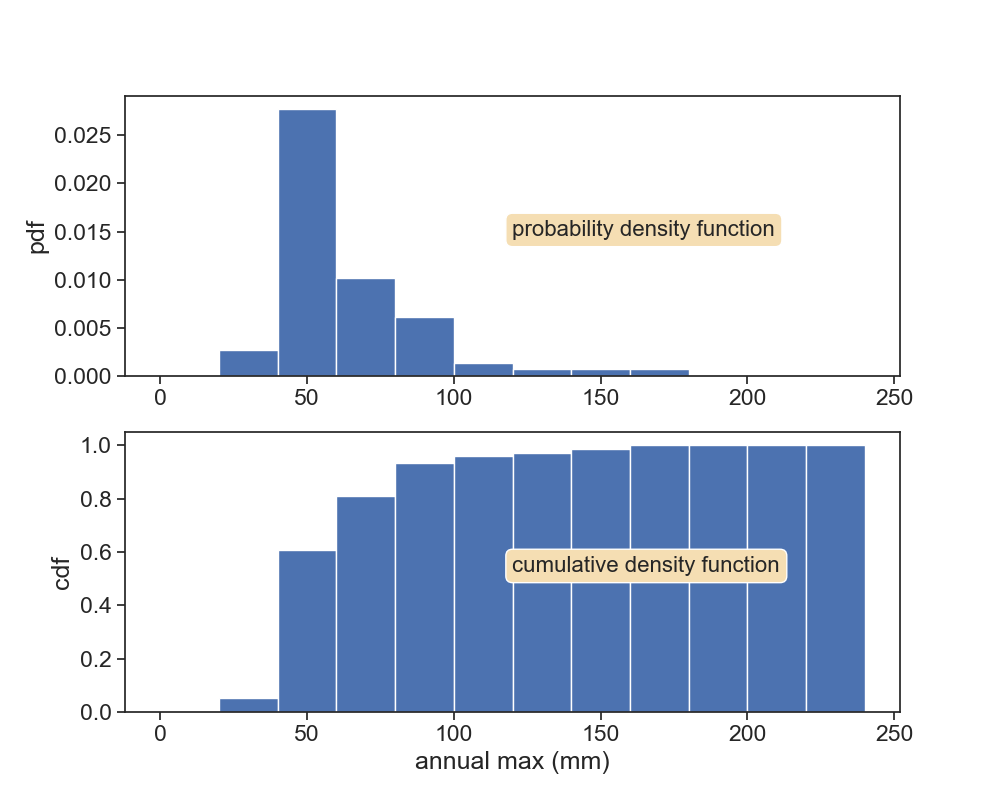

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

h=max_annual['PRCP'].values
ax1.hist(h, bins=np.arange(0,250,20), density=True)
ax2.hist(h, bins=np.arange(0,250,20), cumulative=1, density=True)

ax1.set(ylabel="pdf")
ax2.set(xlabel="annual max (mm)",
        ylabel="cdf",
        )
ax1.text(0.5, 0.5, "probability density function",
         transform=ax1.transAxes, fontsize=16,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))
ax2.text(0.5, 0.5, "cumulative density function",
         transform=ax2.transAxes, fontsize=16,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))

plt.savefig("hydrology_figures/pdf_cdf_bilbao.png")

In [36]:
max_annual.shape[0]

75

Ward, Environmental Hydrology, pages 46-47,  
**Brutsaert, Hydrology, pages 514-516**  

$P_m=$ plotting position, or probability of occurence for each event  
$n=$ total number of events  
$m=$ rank of each event


### Return period:
$$
\text{Return period} = \frac{1}{1-P_m}
$$


#### oldest, and intuitively the simplest:

$$
P_m = \frac{m}{n}
$$

#### another option:

$$
P_m = \frac{m-1}{n}
$$

#### Hazen:

$$
P_m = \frac{m-\frac{1}{2}}{n}
$$

#### Weibull:

$$
P_m = \frac{m}{n+1}
$$


## Return Period

Brutsaert, "Hydrology, an introduction", page 513

$F(x)$ is the CDF of the PDF $f(x)$. $F(x)$ indicates the probability that a certain event above $x$ has *not* occurred (or that an event below $x$ has occurred, same thing).

$1-F(x)$ is the probability that a certain event above $x$ *has* occurred. It's reciprocal is the return period:
$$
T_r(x) = \frac{1}{1-F(x)}
$$

This return period is the expected number of observations required until $x$ is exceeded once.
In our case, we can ask the question: how many years will pass (on average) until we see a rainfall event greater that that of 26 August 1983?

Let's call $p=F(x)$ the probability that we measured once and that an event greater than $x$ has *not* occurred.
What is the probability that a rainfall above $x$ will occur only on year number $k$?  
* it hasn't occurred on year 1 (probability p)
* it hasn't occurred on year 2 (probability p)
* it hasn't occurred on year 3 (probability p)
* ...
* it has occurred on year k (probability 1-p)

$P\{k \text{ trials until }X>x\} = p^{k-1}(1-p)$

Every time the number $k$ will be different. What will be $k$ *on average*?

$$\bar{k} = \displaystyle\sum_{k=1}^{\infty} k P(k) = \displaystyle\sum_{k=1}^{\infty} k p^{k-1}(1-p)$$

Let's open that up:

$$
\begin{align}
\bar{k} &= 1-p + 2p(1-p) + 3p^2(1-p) + 4p^3(1-p)+ \cdots\\
\bar{k} &= 1-p + 2p - 2p^2 + 3p^2 - 3p^4 + 4p^3 - 4p^4+ \cdots \\
\bar{k} &= 1 + p + p^2 + p^3 + p^4 + \cdots
\end{align}
$$

For $p<1$, the series converges to
$$
1 + p + p^2 + p^3 + p^4 + \cdots = \frac{1}{1-p},
$$
therefore
$$
\bar{k} = \frac{1}{1-p}.
$$


<IPython.core.display.Javascript object>


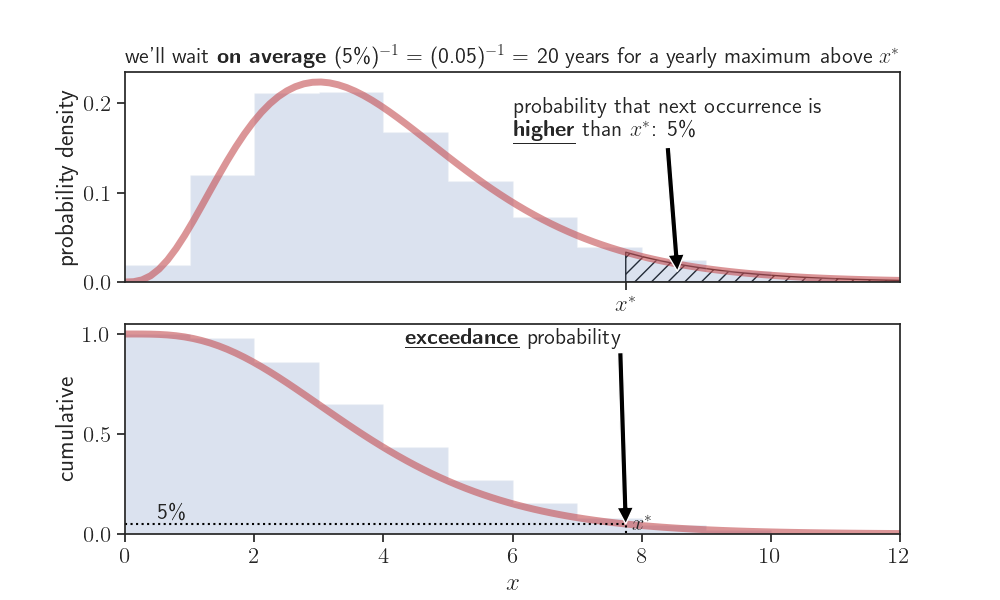

In [10]:
from scipy.stats import gamma
import scipy
from matplotlib import rc
rc('text', usetex=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))#, sharex=True)

a = 4
xmax = 12
b = np.arange(0,13,1)
x = np.linspace(0,
                gamma.ppf(0.999, a), 100)
# x = np.linspace(gamma.ppf(0.001, a),
#                 gamma.ppf(0.999, a), 100)
ax1.plot(x, gamma.pdf(x, a),
        'r-', lw=5, alpha=0.6, label='gamma pdf')

r = gamma.rvs(a, size=10000)
ax1.hist(r, bins=b, density=True, histtype='stepfilled', alpha=0.2)
ax2.hist(r, bins=b, density=True, histtype='stepfilled', alpha=0.2, cumulative=-1)

ax2.plot(x, 1-scipy.special.gammainc(a, x),
       'r-', lw=5, alpha=0.6, label='gamma cdf')

quantile = lambda p: gamma.ppf(1-p, a)
p = 0.05
q = quantile(p)
xfill = np.linspace(q, xmax, 100)
ax1.fill_between(xfill, gamma.pdf(xfill, a), color='None', hatch="//",edgecolor='k')
ax2.plot([0, q, q], [p, p ,0], color="black", ls=":")

ax1.annotate(r"\noindent probability that next occurrence is\\ \textbf{\underline{higher}} than $x^*$:" + " {:.0f}\%".format(100*p),
             xy=(q+0.8, gamma.pdf(q+0.8, a)*0.6), xycoords='data',
             xytext=(0.7, 0.8), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.0))

ax2.annotate(r"\noindent \textbf{\underline{exceedance}} probability",
             xy=(q, 1-scipy.special.gammainc(a, q)), xycoords='data',
             xytext=(0.5, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.0))

ax2.text(q+0.1, 0, r"$x^*$", ha="left", va="bottom", fontsize=16)
ax2.text(0.5, p, r"{:.0f}\%".format(100*p), ha="left", va="bottom", fontsize=16)

ax1.set_title(r"we'll wait \textbf{on average}" +
              " ({:.0f}\%)".format(100*p) + 
              r"$^{-1}=$" + 
              r" ({:.2f})".format(p) + 
              r"$^{-1}=$" + 
              " {:.0f} years\\".format(1/p) + r" for a yearly maximum above $x^*$", fontsize=16)

ax1.set(xlim=[0, xmax],
        ylabel="probability density",
        xticks=[q],
        xticklabels=[r"$x^*$"])
ax2.set(xlim=[0, xmax],
        xlabel=r"$x$",
        ylabel="cumulative")

plt.savefig("hydrology_figures/return_prob_005.png")

In [ ]:
# make an animated gif of all the figures
import imageio
files = ['hydrology_figures/return_prob_050.png',
         'hydrology_figures/return_prob_033.png',
         'hydrology_figures/return_prob_020.png',
         'hydrology_figures/return_prob_010.png',
         'hydrology_figures/return_prob_005.png',]
images = [imageio.imread(file) for file in files]
imageio.mimwrite('hydrology_figures/movie.gif', images, fps=1)

<IPython.core.display.Javascript object>


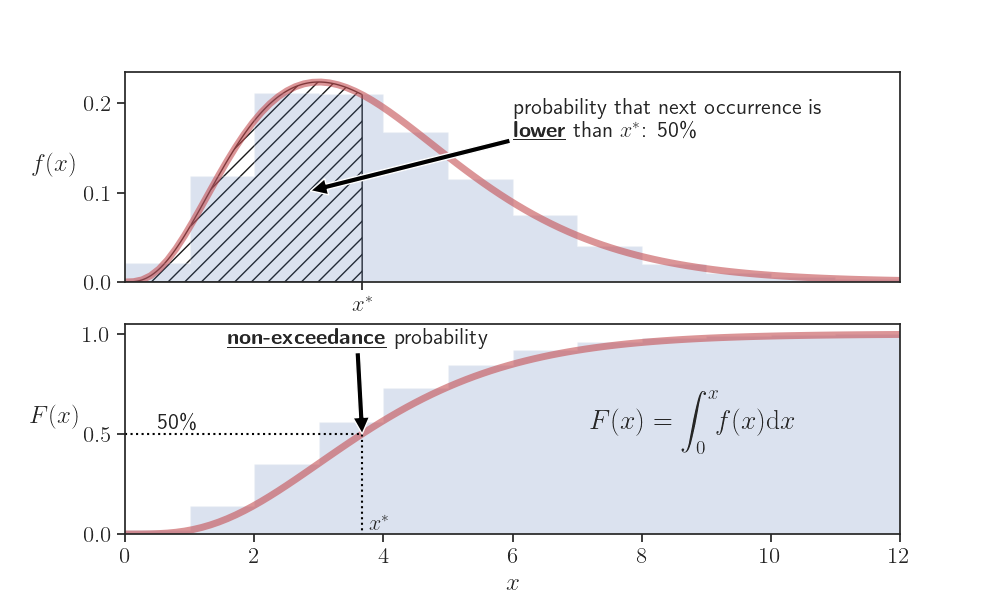

In [23]:
from scipy.stats import gamma
import scipy
from matplotlib import rc
rc('text', usetex=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))#, sharex=True)

a = 4
xmax = 12
b = np.arange(0,13,1)
x = np.linspace(0,
                gamma.ppf(0.999, a), 100)
# x = np.linspace(gamma.ppf(0.001, a),
#                 gamma.ppf(0.999, a), 100)
ax1.plot(x, gamma.pdf(x, a),
        'r-', lw=5, alpha=0.6, label='gamma pdf')

r = gamma.rvs(a, size=10000)
ax1.hist(r, bins=b, density=True, histtype='stepfilled', alpha=0.2)
ax2.hist(r, bins=b, density=True, histtype='stepfilled', alpha=0.2, cumulative=1)

ax2.plot(x, scipy.special.gammainc(a, x),
       'r-', lw=5, alpha=0.6, label='gamma cdf')

quantile = lambda p: gamma.ppf(1-p, a)
p = 0.50
q = quantile(p)
xfill = np.linspace(0, q, 100)
ax1.fill_between(xfill, gamma.pdf(xfill, a), color='None', hatch="//",edgecolor='k')
ax2.plot([0, q, q], [p, p ,0], color="black", ls=":")

ax1.annotate(r"\noindent probability that next occurrence is\\ \textbf{\underline{lower}} than $x^*$:" + " {:.0f}\%".format(100*p),
             xy=(q-0.8, gamma.pdf(q+0.8, a)*0.6), xycoords='data',
             xytext=(0.7, 0.8), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.0))

ax2.annotate(r"\noindent \textbf{\underline{non-exceedance}} probability",
             xy=(q, 1-scipy.special.gammainc(a, q)), xycoords='data',
             xytext=(0.3, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.0))

ax2.text(q+0.1, 0, r"$x^*$", ha="left", va="bottom", fontsize=16)
ax2.text(0.5, p, r"{:.0f}\%".format(100*p), ha="left", va="bottom", fontsize=16)

# ax1.set_title(r"we'll wait \textbf{on average}" +
#               " ({:.0f}\%)".format(100*p) + 
#               r"$^{-1}=$" + 
#               r" ({:.2f})".format(p) + 
#               r"$^{-1}=$" + 
#               " {:.0f} years\\".format(1/p) + r" for a yearly maximum below $x^*$", fontsize=16)


ax2.text(0.6,0.5,r"$\displaystyle F(x)=\int_0^x \!\!f(x)\textrm{d}x$", transform=ax2.transAxes, fontsize=20)

ax1.set_ylabel(r"$f(x)$", rotation="horizontal", labelpad=20)
ax2.set_ylabel(r"$F(x)$", rotation="horizontal", labelpad=20)
ax1.set(xlim=[0, xmax],
        xticks=[q],
        xticklabels=[r"$x^*$"])
ax2.set(xlim=[0, xmax],
        xlabel=r"$x$")

plt.savefig("hydrology_figures/return_prob_050_reversed.png")

<IPython.core.display.Javascript object>


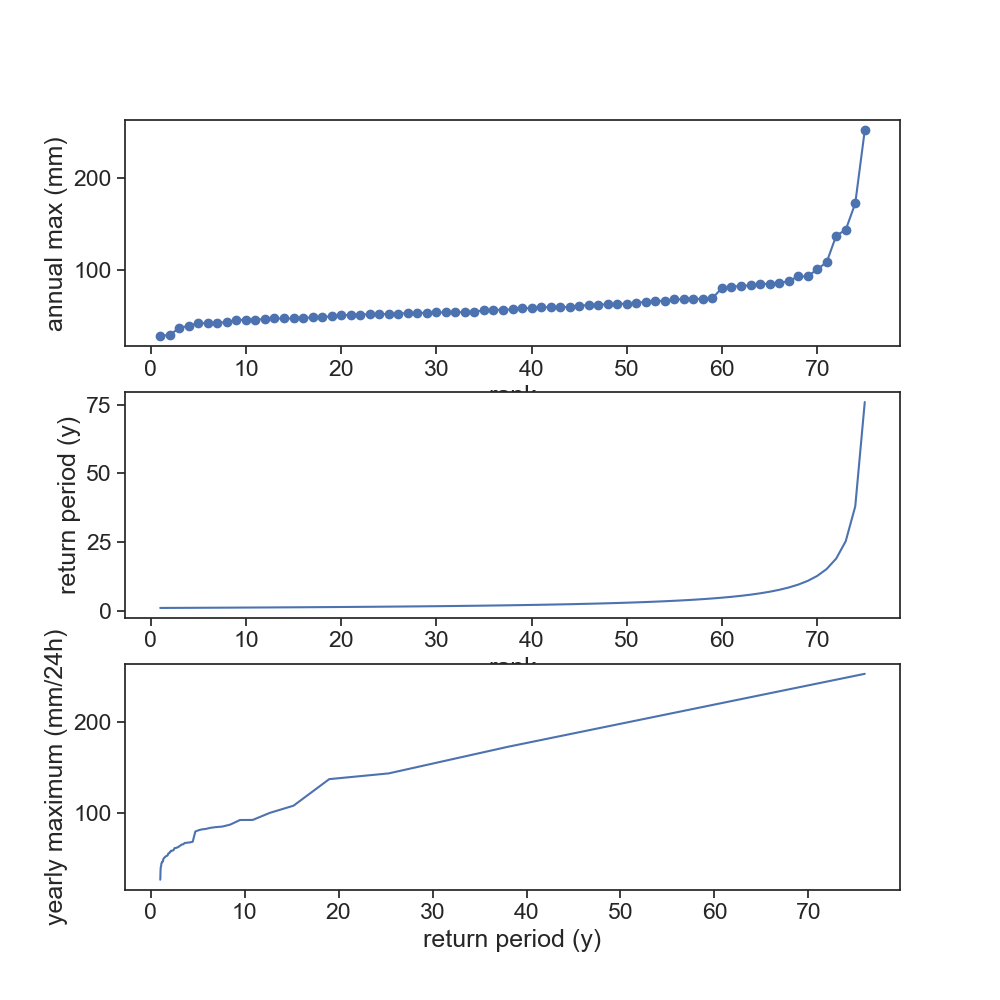

             PRCP  rank
DATE                   
2011-07-31   27.0     1
2002-07-31   28.5     2
2021-07-31   35.8     3
2001-07-31   38.6     4
2004-07-31   41.1     5
...           ...   ...
2010-07-31  108.1    71
1960-07-31  137.2    72
1964-07-31  143.5    73
1954-07-31  172.6    74
1984-07-31  252.6    75

[75 rows x 2 columns]


[Text(0.5, 0, 'return period (y)'), Text(0, 0.5, 'yearly maximum (mm/24h)')]

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
# resample daily data into yearly data (maximum yearly value)
max_annual = df['PRCP'].resample('A-JUL').max().to_frame()
# sort yearly max from highest to lowest
max_annual = max_annual.sort_values(by=['PRCP'], ascending=True)
max_annual['rank'] = np.arange(1, len(max_annual) + 1)
print(max_annual)
# plot annual max vs. rank
ax1.plot(max_annual['rank'], max_annual['PRCP'], '-o')
ax1.set(xlabel="rank",
        ylabel="annual max (mm)")

n = len(max_annual['rank'])
m = max_annual['rank']
Pm = m / (n+1)
Tr = 1 / (1 - Pm)
ax2.plot(max_annual['rank'], Tr)
ax3.plot(Tr, max_annual['PRCP'])

ax2.set(xlabel="rank",
        ylabel="return period (y)")
ax3.set(xlabel="return period (y)",
        ylabel="yearly maximum (mm/24h)")

<IPython.core.display.Javascript object>


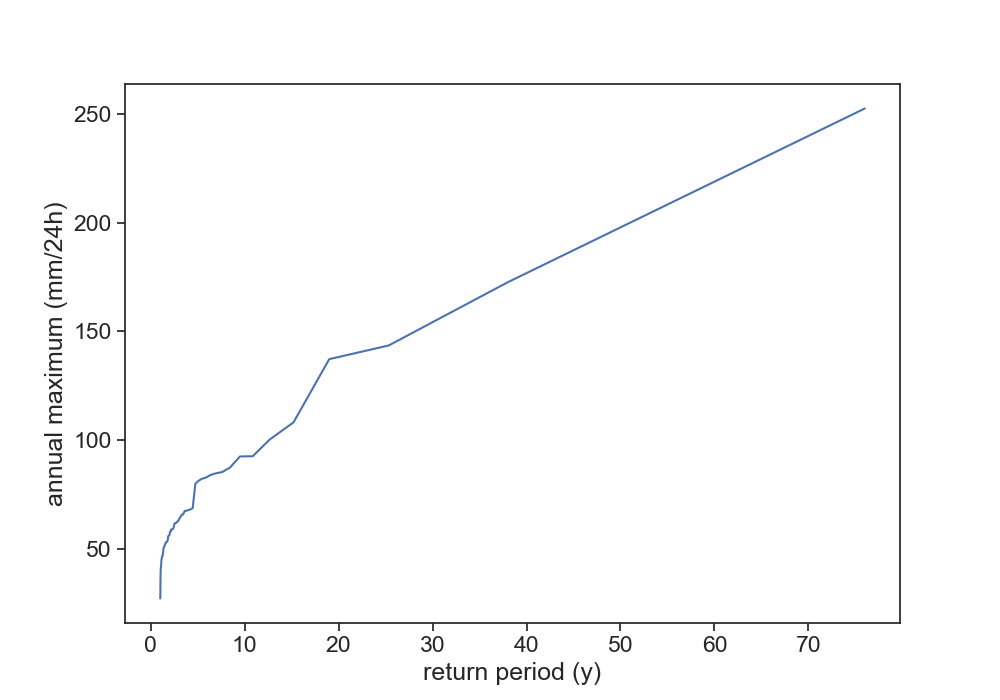

             PRCP  rank
DATE                   
2011-07-31   27.0     1
2002-07-31   28.5     2
2021-07-31   35.8     3
2001-07-31   38.6     4
2004-07-31   41.1     5
...           ...   ...
2010-07-31  108.1    71
1960-07-31  137.2    72
1964-07-31  143.5    73
1954-07-31  172.6    74
1984-07-31  252.6    75

[75 rows x 2 columns]


In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
# resample daily data into yearly data (maximum yearly value)
max_annual = df['PRCP'].resample('A-JUL').max().to_frame()
# sort yearly max from highest to lowest
max_annual = max_annual.sort_values(by=['PRCP'], ascending=True)
max_annual['rank'] = np.arange(1, len(max_annual) + 1)
print(max_annual)
# plot annual max vs. rank
# ax1.plot(max_annual['rank'], max_annual['PRCP'], '-o')
# ax1.set(xlabel="rank",
#         ylabel="annual max (mm)")

n = len(max_annual['rank'])
m = max_annual['rank']
Pm = m / (n+1)
Tr = 1 / (1 - Pm)
# ax2.plot(max_annual['rank'], Tr)
ax.plot(Tr, max_annual['PRCP'])

# ax2.set(xlabel="rank",
#         ylabel="return period (y)")
ax.set(xlabel="return period (y)",
       ylabel="annual maximum (mm/24h)")
plt.savefig("hydrology_figures/annual_max_vs_return_period.png")

In [18]:
Tr

DATE
2011-07-31     1.013333
2002-07-31     1.027027
2021-07-31     1.041096
2001-07-31     1.055556
2004-07-31     1.070423
                ...    
2010-07-31    15.200000
1960-07-31    19.000000
1964-07-31    25.333333
1954-07-31    38.000000
1984-07-31    76.000000
Name: rank, Length: 75, dtype: float64

<IPython.core.display.Javascript object>


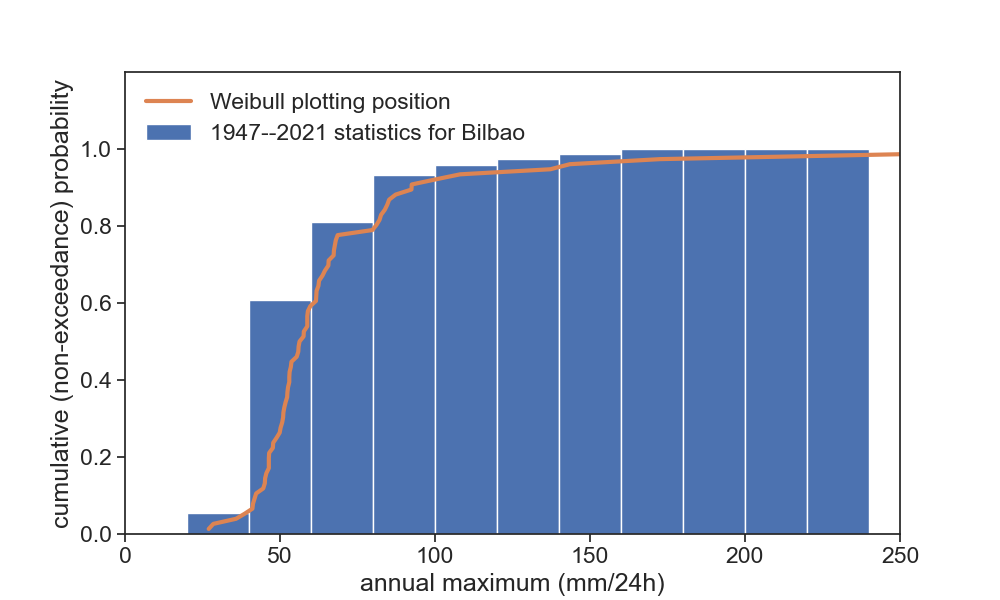

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(h, bins=np.arange(0,250,20), cumulative=1, density=True, label="1947--2021 statistics for Bilbao")
ax.plot(max_annual['PRCP'], Pm, lw=3, label="Weibull plotting position")
ax.set(xlabel="annual maximum (mm/24h)",
       ylabel="cumulative (non-exceedance) probability",
       xlim=[0, 250],
       ylim=[0, 1.2],
       yticks=np.arange(0,1.1,0.2))
ax.legend(loc="upper left", frameon=False)
plt.savefig("hydrology_figures/weibull_plotting_position.png")

<IPython.core.display.Javascript object>


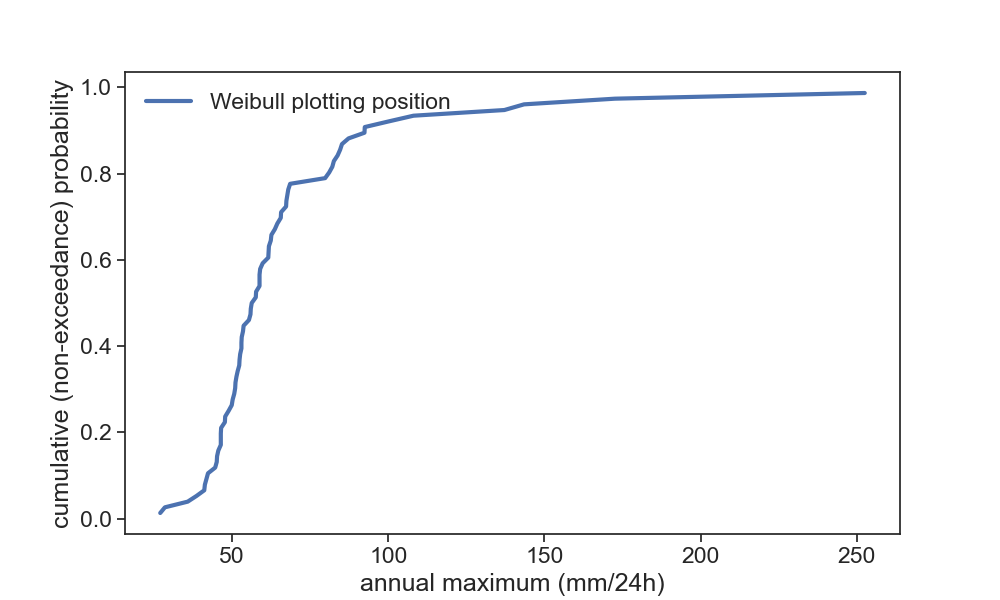

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# ax.hist(h, bins=np.arange(0,2500,200), cumulative=1, density=True, label="1947--2021 statistics for Bilbao")
ax.plot(max_annual['PRCP'], Pm, lw=3, label="Weibull plotting position")
ax.set(xlabel="annual maximum (mm/24h)",
       ylabel="cumulative (non-exceedance) probability")#,
#        xlim=[0, 2500],
#        ylim=[0, 1.2],
#        yticks=np.arange(0,1.1,0.2))
ax.set_xscale("linear")
ax.legend(loc="upper left", frameon=False)

In [11]:
import imageio
files = ['hydrology_figures/return_prob_050.png',
         'hydrology_figures/return_prob_033.png',
         'hydrology_figures/return_prob_020.png',
         'hydrology_figures/return_prob_010.png',
         'hydrology_figures/return_prob_005.png',]
images = [imageio.imread(file) for file in files]
imageio.mimwrite('hydrology_figures/movie.gif', images, fps=1)

<IPython.core.display.Javascript object>


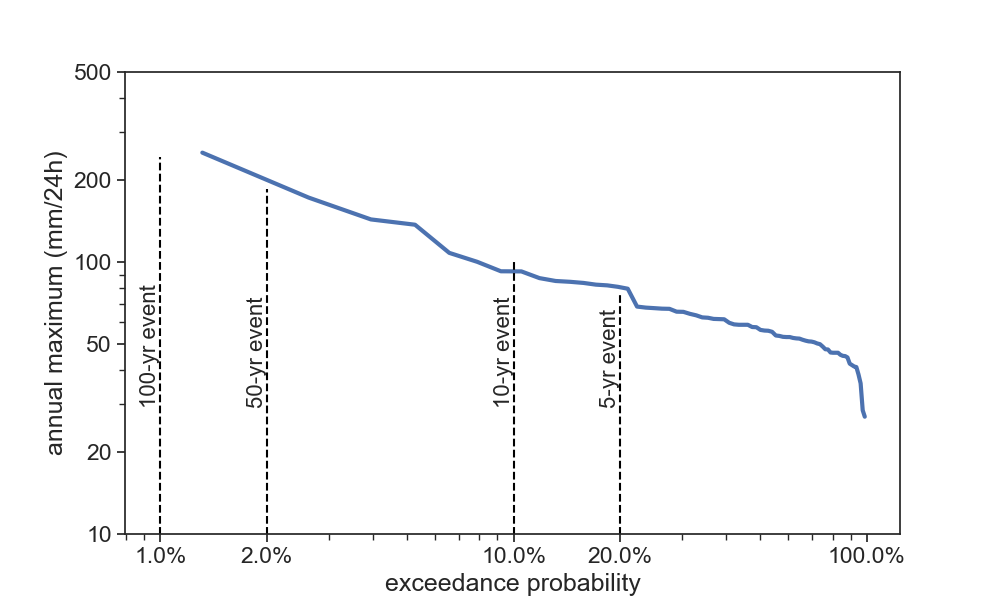

In [27]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10, 6))

depth = max_annual['PRCP'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, lw=3, label="Weibull plotting position")
ax.set(ylabel="annual maximum (mm/24h)",
       xlabel="exceedance probability")
ax.set_xscale("log")
ax.set_yscale("log")

exclude = 40
depth_tofit = depth[exclude:]
exc_prob_tofit = exc_prob[exclude:]

# ax.plot(exc_prob_tofit, depth_tofit, 'o')

exc_prob_tofit_log = np.log(exc_prob_tofit)
depth_tofit_log = np.log(depth_tofit)
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1)


prob = [1e-3,1-1e-3]

def equation(p):
    return np.exp(slope*np.log(p) + intercept)

# ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)

one_in_x_years = np.array([5, 10, 50, 100])#, 200, 1000])

for y in one_in_x_years:
    ax.plot([1/y]*2, [0, equation(1/y)], color="black", ls="--")
    ax.text(1/y, 30, f"{y}-yr event", rotation=90, ha="right", fontsize=16)

ax.set_xticks([0.01, 0.02, 0.1, 0.2, 1.0])
ax.set_yticks([10, 20, 50, 100, 200, 500])

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))


# ax.annotate(f"{equation(1/5):.0f} mm",
#             xy=(1/5, equation(1/5)), xycoords='data',
#              xytext=(0.8, 0.6), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/10):.0f} mm",
#             xy=(1/10, equation(1/10)), xycoords='data',
#              xytext=(0.7, 0.7), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/50):.0f} mm",
#             xy=(1/50, equation(1/50)), xycoords='data',
#              xytext=(0.6, 0.8), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/100):.0f} mm",
#             xy=(1/100, equation(1/100)), xycoords='data',
#              xytext=(0.5, 0.9), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/200):.0f} mm",
#             xy=(1/200, equation(1/200)), xycoords='data',
#              xytext=(0.35, 0.9), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/1000):.0f} mm",
#             xy=(1/1000, equation(1/1000)), xycoords='data',
#              xytext=(0.2, 0.95), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig("hydrology_figures/extrapolation_exceedance1.png")

<IPython.core.display.Javascript object>


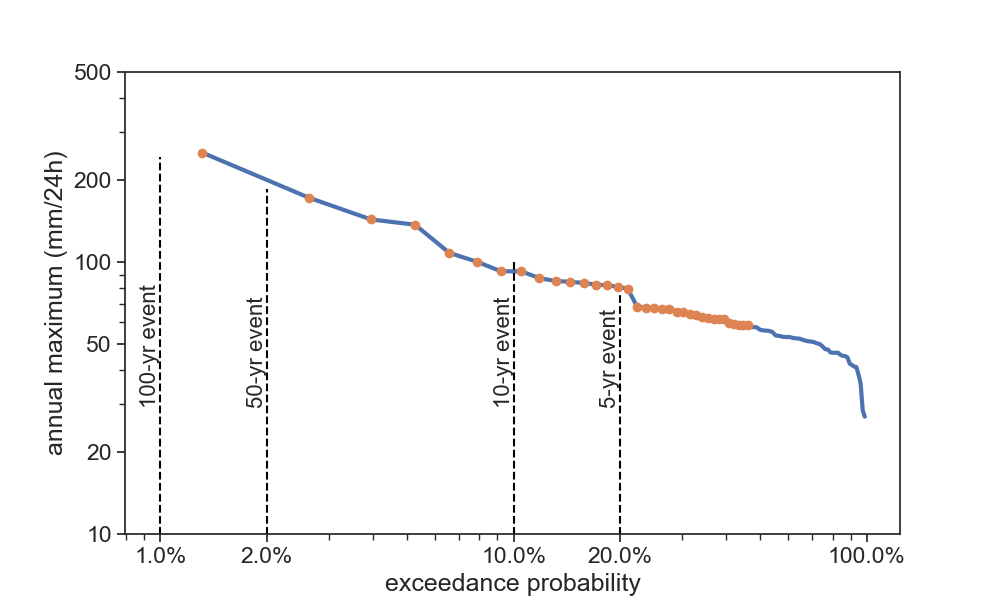

In [28]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10, 6))

depth = max_annual['PRCP'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, lw=3, label="Weibull plotting position")
ax.set(ylabel="annual maximum (mm/24h)",
       xlabel="exceedance probability")
ax.set_xscale("log")
ax.set_yscale("log")

exclude = 40
depth_tofit = depth[exclude:]
exc_prob_tofit = exc_prob[exclude:]

ax.plot(exc_prob_tofit, depth_tofit, 'o')

exc_prob_tofit_log = np.log(exc_prob_tofit)
depth_tofit_log = np.log(depth_tofit)
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1)


prob = [1e-3,1-1e-3]

def equation(p):
    return np.exp(slope*np.log(p) + intercept)

# ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)

one_in_x_years = np.array([5, 10, 50, 100])#, 200, 1000])

for y in one_in_x_years:
    ax.plot([1/y]*2, [0, equation(1/y)], color="black", ls="--")
    ax.text(1/y, 30, f"{y}-yr event", rotation=90, ha="right", fontsize=16)

ax.set_xticks([0.01, 0.02, 0.1, 0.2, 1.0])
ax.set_yticks([10, 20, 50, 100, 200, 500])

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))


# ax.annotate(f"{equation(1/5):.0f} mm",
#             xy=(1/5, equation(1/5)), xycoords='data',
#              xytext=(0.8, 0.6), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/10):.0f} mm",
#             xy=(1/10, equation(1/10)), xycoords='data',
#              xytext=(0.7, 0.7), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/50):.0f} mm",
#             xy=(1/50, equation(1/50)), xycoords='data',
#              xytext=(0.6, 0.8), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/100):.0f} mm",
#             xy=(1/100, equation(1/100)), xycoords='data',
#              xytext=(0.5, 0.9), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/200):.0f} mm",
#             xy=(1/200, equation(1/200)), xycoords='data',
#              xytext=(0.35, 0.9), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/1000):.0f} mm",
#             xy=(1/1000, equation(1/1000)), xycoords='data',
#              xytext=(0.2, 0.95), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig("hydrology_figures/extrapolation_exceedance2.png")

<IPython.core.display.Javascript object>


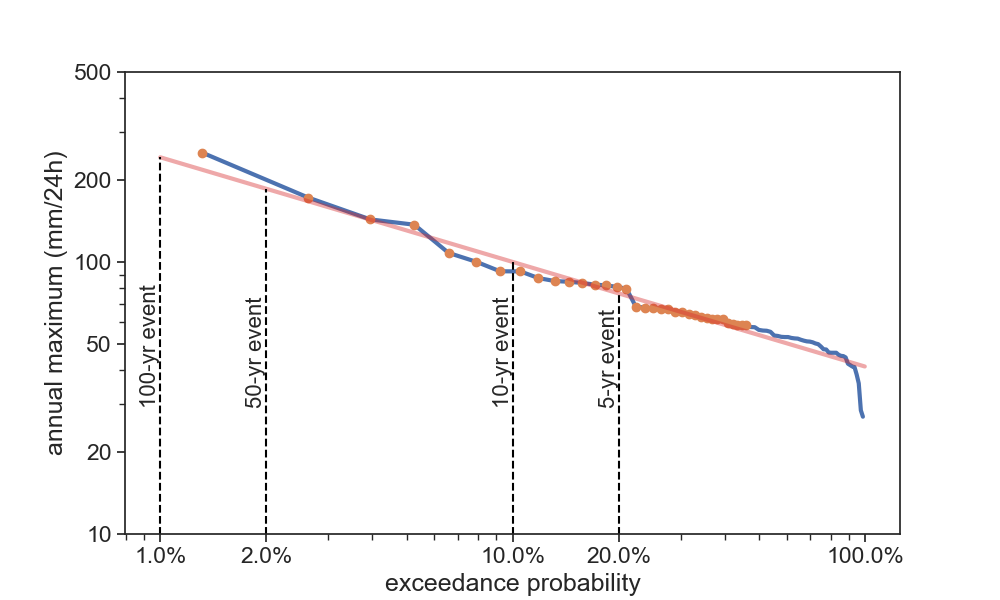

In [29]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10, 6))

depth = max_annual['PRCP'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, lw=3, label="Weibull plotting position")
ax.set(ylabel="annual maximum (mm/24h)",
       xlabel="exceedance probability")
ax.set_xscale("log")
ax.set_yscale("log")

exclude = 40
depth_tofit = depth[exclude:]
exc_prob_tofit = exc_prob[exclude:]

ax.plot(exc_prob_tofit, depth_tofit, 'o')

exc_prob_tofit_log = np.log(exc_prob_tofit)
depth_tofit_log = np.log(depth_tofit)
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1)


prob = [1e-2,1-1e-3]

def equation(p):
    return np.exp(slope*np.log(p) + intercept)

ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)

one_in_x_years = np.array([5, 10, 50, 100])#, 200, 1000])

for y in one_in_x_years:
    ax.plot([1/y]*2, [0, equation(1/y)], color="black", ls="--")
    ax.text(1/y, 30, f"{y}-yr event", rotation=90, ha="right", fontsize=16)

ax.set_xticks([0.01, 0.02, 0.1, 0.2, 1.0])
ax.set_yticks([10, 20, 50, 100, 200, 500])

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))


# ax.annotate(f"{equation(1/5):.0f} mm",
#             xy=(1/5, equation(1/5)), xycoords='data',
#              xytext=(0.8, 0.6), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/10):.0f} mm",
#             xy=(1/10, equation(1/10)), xycoords='data',
#              xytext=(0.7, 0.7), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/50):.0f} mm",
#             xy=(1/50, equation(1/50)), xycoords='data',
#              xytext=(0.6, 0.8), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/100):.0f} mm",
#             xy=(1/100, equation(1/100)), xycoords='data',
#              xytext=(0.5, 0.9), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/200):.0f} mm",
#             xy=(1/200, equation(1/200)), xycoords='data',
#              xytext=(0.35, 0.9), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f"{equation(1/1000):.0f} mm",
#             xy=(1/1000, equation(1/1000)), xycoords='data',
#              xytext=(0.2, 0.95), textcoords='axes fraction',
#              fontsize=16, horizontalalignment="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig("hydrology_figures/extrapolation_exceedance3.png")

<IPython.core.display.Javascript object>


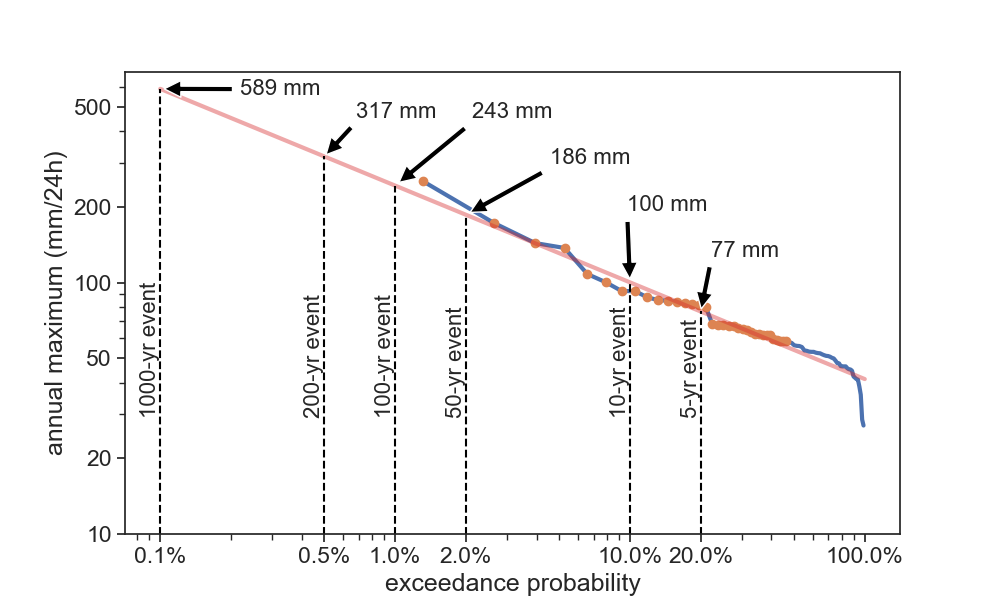

In [31]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10, 6))

depth = max_annual['PRCP'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, lw=3, label="Weibull plotting position")
ax.set(ylabel="annual maximum (mm/24h)",
       xlabel="exceedance probability")
ax.set_xscale("log")
ax.set_yscale("log")

exclude = 40
depth_tofit = depth[exclude:]
exc_prob_tofit = exc_prob[exclude:]

ax.plot(exc_prob_tofit, depth_tofit, 'o')

exc_prob_tofit_log = np.log(exc_prob_tofit)
depth_tofit_log = np.log(depth_tofit)
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1)


prob = [1e-3,1-1e-3]

def equation(p):
    return np.exp(slope*np.log(p) + intercept)

ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)

one_in_x_years = np.array([5, 10, 50, 100, 200, 1000])

for y in one_in_x_years:
    ax.plot([1/y]*2, [0, equation(1/y)], color="black", ls="--")
    ax.text(1/y, 30, f"{y}-yr event", rotation=90, ha="right", fontsize=16)

ax.set_xticks([0.001, 0.005, 0.01, 0.02, 0.1, 0.2, 1.0])
ax.set_yticks([10, 20, 50, 100, 200, 500])

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))


ax.annotate(f"{equation(1/5):.0f} mm",
            xy=(1/5, equation(1/5)), xycoords='data',
             xytext=(0.8, 0.6), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/10):.0f} mm",
            xy=(1/10, equation(1/10)), xycoords='data',
             xytext=(0.7, 0.7), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/50):.0f} mm",
            xy=(1/50, equation(1/50)), xycoords='data',
             xytext=(0.6, 0.8), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/100):.0f} mm",
            xy=(1/100, equation(1/100)), xycoords='data',
             xytext=(0.5, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/200):.0f} mm",
            xy=(1/200, equation(1/200)), xycoords='data',
             xytext=(0.35, 0.9), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f"{equation(1/1000):.0f} mm",
            xy=(1/1000, equation(1/1000)), xycoords='data',
             xytext=(0.2, 0.95), textcoords='axes fraction',
             fontsize=16, horizontalalignment="center",
             arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig("hydrology_figures/extrapolation_exceedance4.png")

<IPython.core.display.Javascript object>


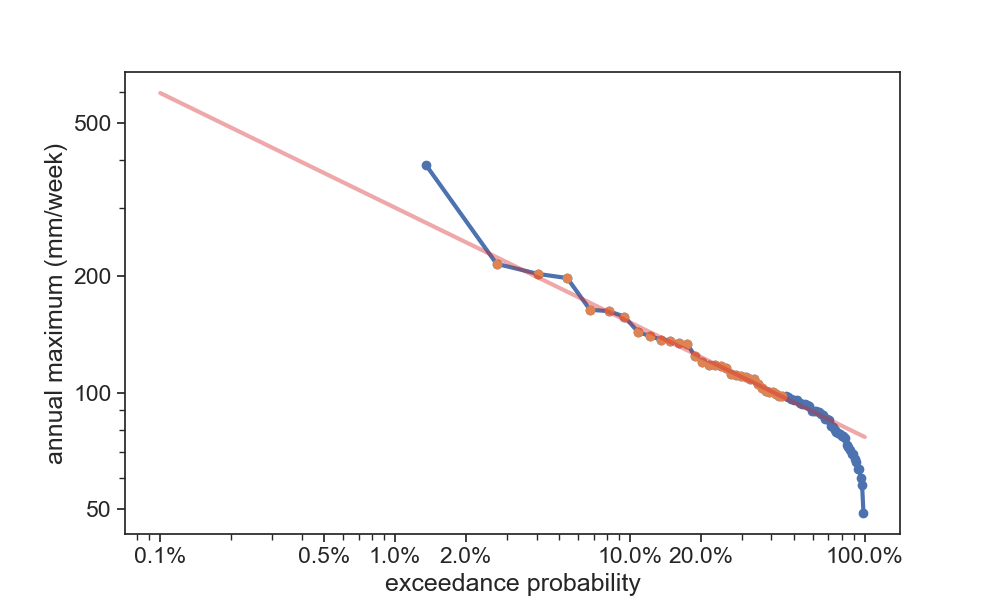

In [32]:
df7days = (df['PRCP'].rolling(3)
                     .sum()
                     .dropna()
          )
annual_7days = (df7days.resample('A-JUL')
                       .max()
                       .to_frame()
               )
annual_7days = annual_7days.reset_index()
annual_7days = (annual_7days.iloc[1:-1]
                            .sort_values(by=['PRCP'], ascending=True)
               )
annual_7days['rank'] = np.arange(1, len(annual_7days) + 1)
n = len(annual_7days['rank'])
m = annual_7days['rank']
Pm = m / (n+1)

fig, ax = plt.subplots(figsize=(10, 6))

depth = annual_7days['PRCP'].values
exc_prob = (1-Pm).values

ax.plot(exc_prob, depth, '-o', lw=3, label="Weibull plotting position")
ax.set(ylabel="annual maximum (mm/week)",
       xlabel="exceedance probability")
ax.set_xscale("log")
ax.set_yscale("log")

exclude = 40
depth_tofit = depth[exclude:-1]
exc_prob_tofit = exc_prob[exclude:-1]
ax.plot(exc_prob_tofit, depth_tofit, 'o')

exc_prob_tofit_log = np.log(exc_prob_tofit)
depth_tofit_log = np.log(depth_tofit)
slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1)

prob = [1e-3,1-1e-3]
def equation(p):
    return np.exp(slope*np.log(p) + intercept)
ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)

ax.set_xticks([0.001, 0.005, 0.01, 0.02, 0.1, 0.2, 1.0])
ax.set_yticks([50, 100, 200, 500])

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.1f}%'.format(x*100)))

<IPython.core.display.Javascript object>


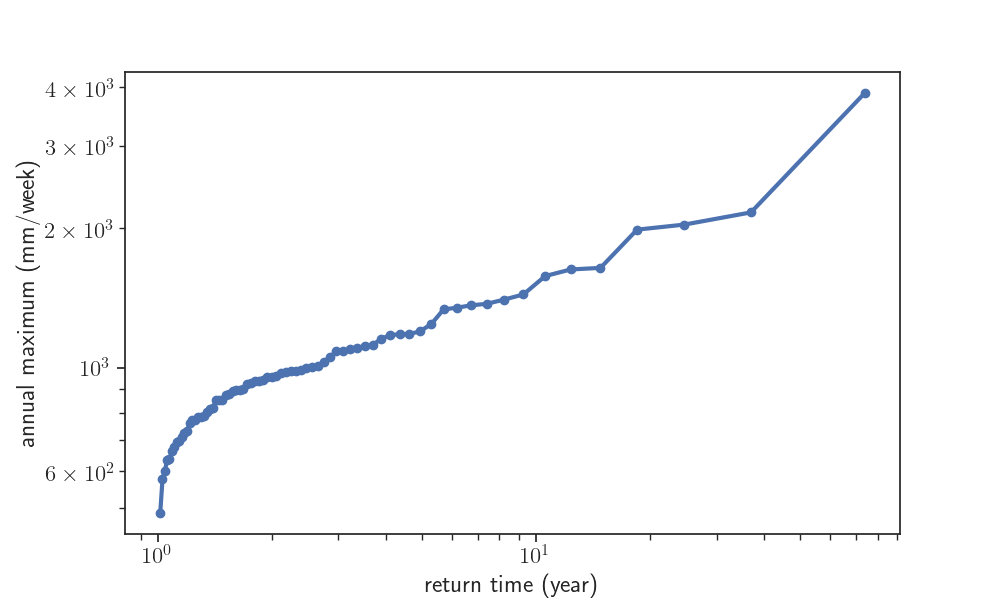

In [225]:
df7days = (df['PRCP'].rolling(3)
                     .sum()
                     .dropna()
          )
annual_7days = (df7days.resample('A-JUL')
                       .max()
                       .to_frame()
               )
annual_7days = annual_7days.reset_index()
annual_7days = (annual_7days.iloc[1:-1]
                            .sort_values(by=['PRCP'], ascending=True)
               )
annual_7days['rank'] = np.arange(1, len(annual_7days) + 1)
n = len(annual_7days['rank'])
m = annual_7days['rank']
Pm = m / (n+1)

fig, ax = plt.subplots(figsize=(10, 6))

depth = annual_7days['PRCP'].values
exc_prob = (1-Pm).values
ret_time = 1 / exc_prob

ax.plot(ret_time, depth, '-o', lw=3, label="Weibull plotting position")
ax.set(ylabel="annual maximum (mm/week)",
       xlabel="return time (year)")
ax.set_xscale("log")
ax.set_yscale("log")

# exclude = 40
# depth_tofit = depth[exclude:-1]
# exc_prob_tofit = exc_prob[exclude:-1]
# ax.plot(exc_prob_tofit, depth_tofit, 'o')

# exc_prob_tofit_log = np.log(exc_prob_tofit)
# depth_tofit_log = np.log(depth_tofit)
# slope, intercept = np.polyfit(exc_prob_tofit_log, depth_tofit_log, 1)

# prob = [1e-3,1-1e-3]
# def equation(p):
#     return np.exp(slope*np.log(p) + intercept)
# ax.plot(prob, equation(prob), lw=3, color="tab:red", alpha=0.4)

# ax.set_xticks([0.001, 0.005, 0.01, 0.02, 0.1, 0.2, 1.0])
# ax.set_yticks([500, 1000, 2000, 5000])

# ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
# ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.1f}\%'.format(x*100)))